In [70]:
#Import packages
import re
import multiprocessing
from math import radians, sin, cos, atan2, sqrt
import pytz
import pandas as pd
import numpy as np
from datetime import datetime, date, time, timedelta

from IPython.display import Image, display
import itertools
import folium
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

# pypower
from pypower import data_utils as util
from pypower import preprocessing as prep
from pypower import model_selection as mod_sel

In [6]:
data_dir = "/Users/dmatekenya/Google Drive/World-Bank/electricity_monitoring/01.data"

In [148]:
sms1 = pd.read_csv(data_dir + '/processed_sms/sms_observed.csv')
sms2 = pd.read_csv(data_dir + '/processed_sms/sms_rect_hr.csv')
cols = ['box_id', 'region', 'district', 'urban_rural', 'psu', 'lon', 'lat', 'event_type_str', 'power_state', 
       'datetime_sent_raw', 'datetime_received', 'str_datetime_sent',
       'str_datetime_sent_hr', 'day_sent', 'hour_sent', 'month_sent',
       'wk_day_sent', 'wk_end', 'event_type_num',
       'ping_event', 'data_source']
sms2 = sms2[cols]

In [149]:
sms2.head()

box_id region district urban_rural  psu        lon        lat  \
0    1024    DRS   Vahdat       Rural   35  69.075835  38.563905   
1    1024    DRS   Vahdat       Rural   35  69.075835  38.563905   
2    1024    DRS   Vahdat       Rural   35  69.075835  38.563905   
3    1024    DRS   Vahdat       Rural   35  69.075835  38.563905   
4    1024    DRS   Vahdat       Rural   35  69.075835  38.563905   

  event_type_str  power_state  datetime_sent_raw       ...        \
0          pfail            0       1.479834e+12       ...         
1          pfail            0                NaN       ...         
2          pfail            0                NaN       ...         
3          pfail            0                NaN       ...         
4          pfail            0                NaN       ...         

     str_datetime_sent str_datetime_sent_hr day_sent  hour_sent  month_sent  \
0  2016-11-22 22:02:34  2016-11-22 22:00:00       22         22          11   
1  2016-11-22 23:00:00  2016-11-22 23:00:00       22         23          11   
2  2016-11-23 00:00:00  2016-11-23 00:00:00       23          0          11   
3  2016-11-23 01:00:00  2016-11-23 01:00:00       23          1          11   
4  2016-11-23 02:00:00  2016-11-23 02:00:00       23          2          11   

   wk_day_sent  wk_end  event_type_num  ping_event     data_source  
0            1       0               2           0  observed_event  
1            1       0               2           0       insertion  
2            2       0               2           0       insertion  
3            2       0               2           0       insertion  
4            2       0               2           0       insertion  

[5 rows x 21 columns]

In [139]:
sms2.columns

Index(['box_id', 'region', 'district', 'urban_rural', 'psu', 'lon', 'lat',
       'datetime_sent_raw', 'datetime_received', 'str_datetime_sent',
       'str_datetime_sent_hr', 'day_sent', 'hour_sent', 'month_sent',
       'wk_day_sent', 'wk_end', 'event_type_str', 'event_type_num',
       'power_state', 'ping_event', 'data_source'],
      dtype='object')

In [150]:
from prettytable import PrettyTable
x = PrettyTable(field_names=['Event_type', 'Proportion (%)'])
counts = sms2['event_type_str'].value_counts(normalize=True)
for idx in counts.index:
    x.add_row([idx, round(counts[idx] * 100, 4)])
print(x)

+------------+----------------+
| Event_type | Proportion (%) |
+------------+----------------+
|  pon_mon   |    55.0715     |
|  missing   |    21.6146     |
|   pback    |     11.429     |
|   pfail    |     6.4624     |
| pfail_mon  |     5.4224     |
+------------+----------------+


-------------------------------------------------------------------
-------------------------------------------------------------------
# DATA FOR MODEL SELECTION-METADATA
-------------------------------------------------------------------
-------------------------------------------------------------------

1. Which dataset is being used?
2. Data size (sms_observed, sms_rect_hr)
3. Summary of stats for target variables (event_type, power_state)


## WHICH DATASET IS BEING USED ?
---------------------------------------------
In order to evaluate the model, I'm using *sms_rect_hr.csv* 

(refer to the data processing workflow for details of what 

this file contain) with missing events omitted.

*Note that the training data containts inserted events *. In terms of 

the currency, the current evelaution results are based on 

**sms.xml updated on August 30, 2017**.

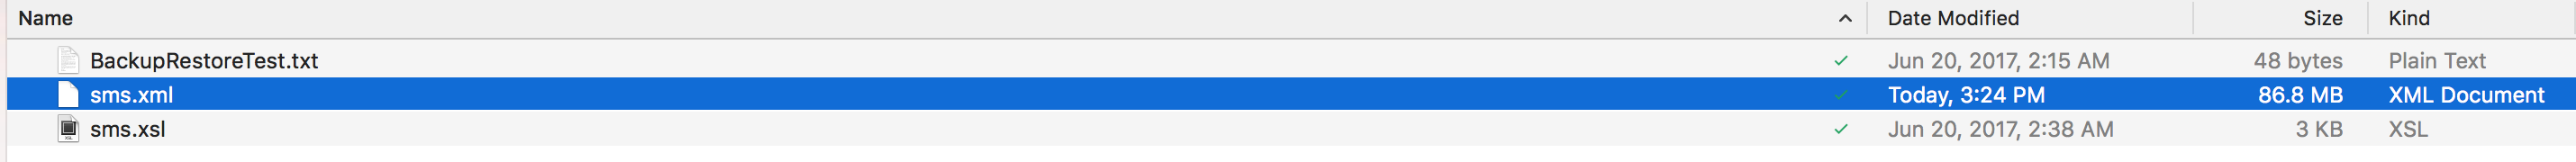

In [56]:
Image(filename='sms.png')

## DATA SIZE (sms_observed, sms_rect_hr)
---------------------------------------------------------
A brief summary of the *sms_observed.csv* and *sms_rect_hr.csv*
are presented below.

In [53]:
print('===============================================')
print('DESCRIPTION FOR SMS_OBSERVED.CSV')
print('===============================================')
print('Number of actual events===> {:,}'.format(sms1.shape[0]))

print()
print('-----------------------------------')
print('Distribution of event_type_str...')
print('------------------------------------')
display(sms1['event_type_str'].value_counts(dropna=False,normalize=True))

print('-------------------------------------')
print('Distribution of event_type_num......')
print('-------------------------------------')
display(sms1['event_type_num'].value_counts(dropna=False,normalize=True))

print('-----------------------------------------------')
print ('Mapping from event_type_str to event_type_num ')
print('-----------------------------------------------')
event_type = {'test': 0, 'pback': 1, 'pfail': 2, 'pon_mon': 3, 'pfail_mon': 4, 'missing': -1}
for event,index in event_type.items():
    print(event+'====>{}'.format(index))

print()
print('----------------------------------------------')
print ('Mapping from event_type_num to power_state')
print('----------------------------------------------')
power_state_dict = {'pback': 1, 'pfail': 0, 'pon_mon': 1, 'pfail_mon': 0, 'missing': -1}
for event,index in power_state_dict.items():
    print(event+'====>{}'.format(index))

DESCRIPTION FOR SMS_OBSERVED.CSV
Number of actual events===> 243,984

-----------------------------------
Distribution of event_type_str...
------------------------------------


pon_mon      0.402834
pfail        0.268317
pback        0.261353
pfail_mon    0.067496
Name: event_type_str, dtype: float64

-------------------------------------
Distribution of event_type_num......
-------------------------------------


3    0.402834
2    0.268317
1    0.261353
4    0.067496
Name: event_type_num, dtype: float64

-----------------------------------------------
Mapping from event_type_str to event_type_num 
-----------------------------------------------
pback====>1
pon_mon====>3
missing====>-1
test====>0
pfail_mon====>4
pfail====>2

----------------------------------------------
Mapping from event_type_num to power_state
----------------------------------------------
pback====>1
pon_mon====>1
pfail====>0
pfail_mon====>0
missing====>-1


In [55]:
print('=======================================')
print('DESCRIPTION FOR SMS_RECT_HR.CSV')
print('=======================================')
print('Number of all events===> {:,}'.format(sms2.shape[0]))

print()
print('------------------------------------')
print('Distribution of event_type_str......')
print('-------------------------------------')
display(sms2['event_type_str'].value_counts(dropna=False,normalize=True))

print()
print('------------------------------------')
print('Distribution of event_type_num......')
print('------------------------------------')
display(sms2['event_type_num'].value_counts(dropna=False, normalize=True))

sms3 = sms2[sms2.event_type_num != -1]
print()
print('Number of events for model evaluation (without missing events) ===> {:,}'.format(sms3.shape[0]))

print()
print('-----------------------------------------------------')
print('Distribution of power_state (without missing events)')
print('-----------------------------------------------------')
display(sms3['power_state'].value_counts(dropna=False, normalize=True))

DESCRIPTION FOR SMS_RECT_HR.CSV
Number of all events===> 1,638,848

------------------------------------
Distribution of event_type_str......
-------------------------------------


pon_mon      0.549617
missing      0.216783
pback        0.114436
pfail        0.064800
pfail_mon    0.054364
Name: event_type_str, dtype: float64


------------------------------------
Distribution of event_type_num......
------------------------------------


 3    0.549617
-1    0.216783
 1    0.114436
 2    0.064800
 4    0.054364
Name: event_type_num, dtype: float64


Number of events for model evaluation (without missing events) ===> 1,283,573

-----------------------------------------------------
Distribution of power_state (without missing events)
-----------------------------------------------------


1    0.847854
0    0.152146
Name: power_state, dtype: float64

---------------------------------------------------------
---------------------------------------------------------
# EXPERIMENT DETAILS
---------------------------------------------------------
---------------------------------------------------------
1. Models under consideration
2. Experiment set-up and perfomance metric
3. Model selection parameters


## MODELS UNDER CONSIDERATION
--------------------------------------------------------------

In this experiment, we consider, the following out of the box models from 
the Python package scikit-learn:
 - Random forest (RF)
 - Extremely random trees (ETC)
 - Gradient boosting classifier (GBM)
 - Logisic regression (LR)
 - K-nearest neighbors classifier (KNN)
 
 
 ## EXPERIMENT SET-UP & PERFOMANCE METRIC
 ----------------------------------------------------------------
 
 All results are based on 5-fold cross validation. The number of folds could be increased 
 but its better to test on the whole dataset than increase the number of folds. The metric is 
 *median accuracy* (percent) across the number of folds. 
 
 
 ## MODEL SELECTION HYPER-PARAMETERS
 --------------------------------------------------------------
 We consider the following parameters:
  - Target variable ('event_type' or power_state')
  - Temporal variations
  - Spatial variations
 
### Temporal variations
In order to check if predictability varies by time. We do the following:
    - Put data in into monthly buckets and evaluate the model
    - Put the data into quartely buckets
    
### Spatial variations

---------------------------------------------------------
---------------------------------------------------------
# EXPERIMENT RESULTS
---------------------------------------------------------
---------------------------------------------------------

** TARGET VARIABLE: power_state vs. event_type_num**

-------------------------------
In the screenshot below, the experiment was run 3 times for each model (k = 3). The results show its much easier
to predict *power_state* than it is to predict *event_type*. This could be due to the fact that predicting power_state is a binary classification task with less entropy compared to event_type which is a multinomial variable. These results are based on  all the available data.

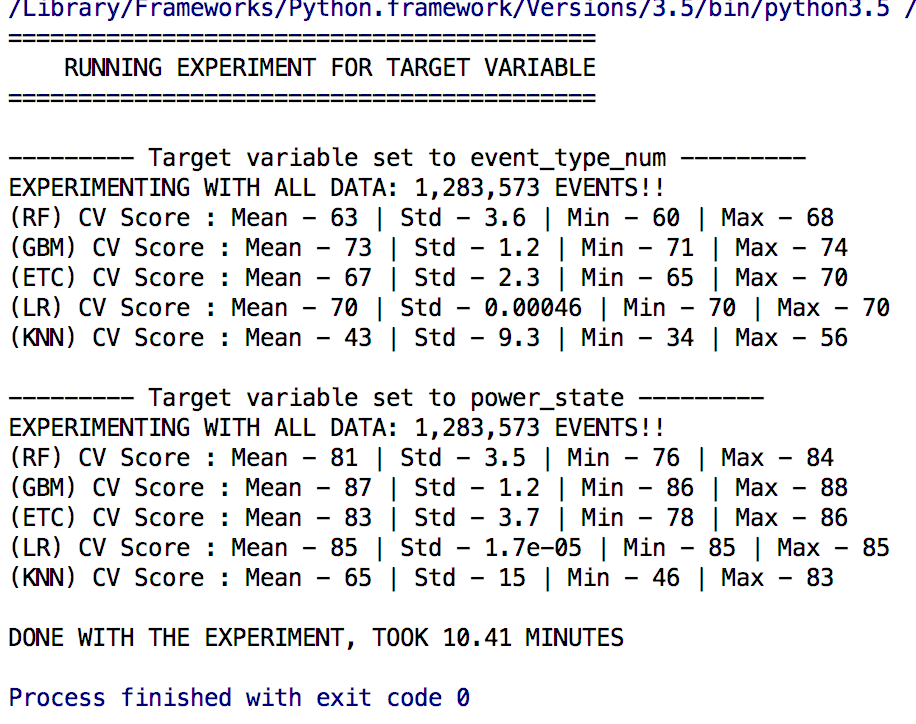

In [22]:
Image(filename='experiment_results_target_all_cv3.png')

**EXTENSIVE CROSS-VALIDATION**
---------------------------------------------------------
Based on our previous meeting, it seems reasonable to use **power_state**  as a target variable. 
From now on, I use power_state as the target variable for prediction. In the results below, 
I did an extensive cross-validation (k = 10) on the whole dataset with including **inserted events**. 

I can bet on these results !!!

**Strangely, Logistic regression has the highest median accuracy of 85 percent and is also very stable!!!**

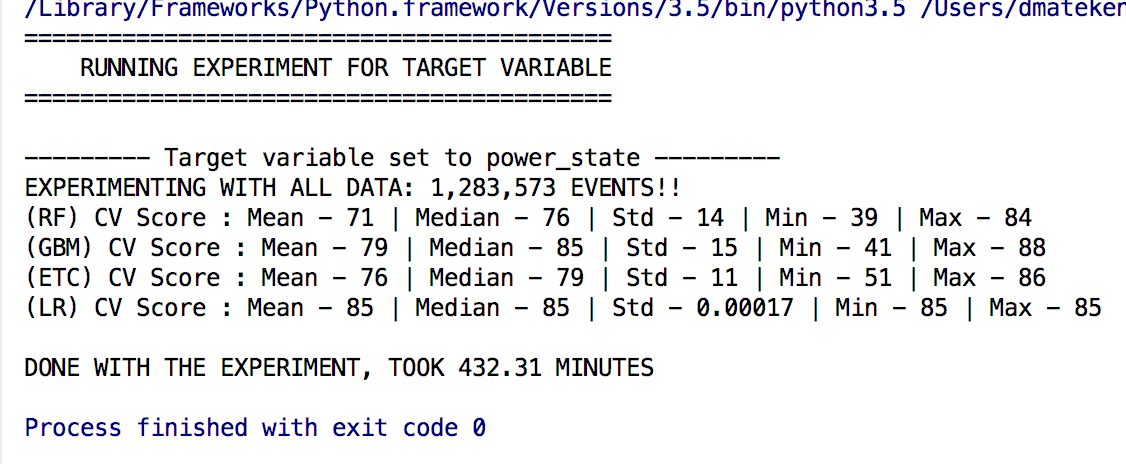

In [14]:
Image(filename='10k_all_data_.png')

** WHAT IF WE ONLY USE OBSERVED EVENTS**
======================


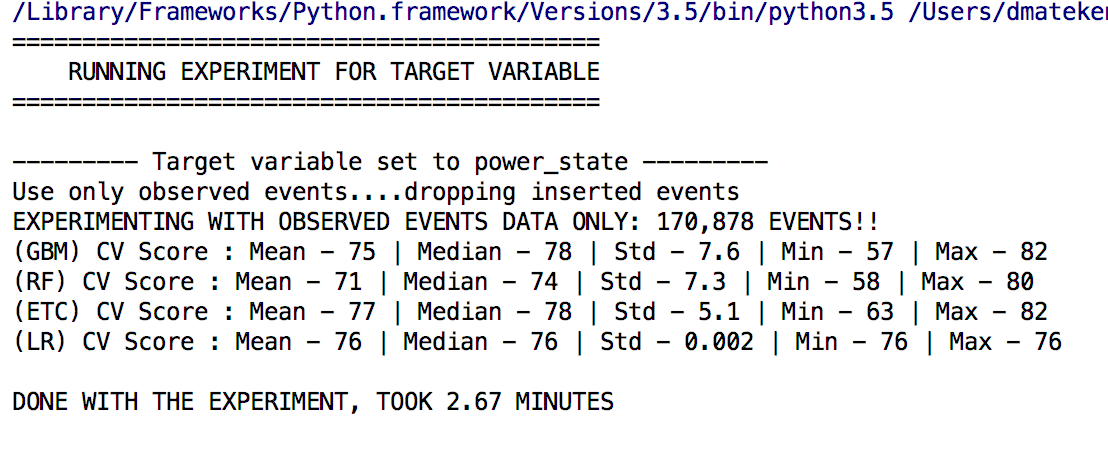

In [18]:
Image(filename='10k_observed_only.png')

** SEASONALITY-MODEL PERFOMANCE BY QUARTER**
-----------------------------------------
Note that for fast throughut, K is set to 3.
Data split into three quarters. Quick inspection shows that perfomance varies alot by quarter.

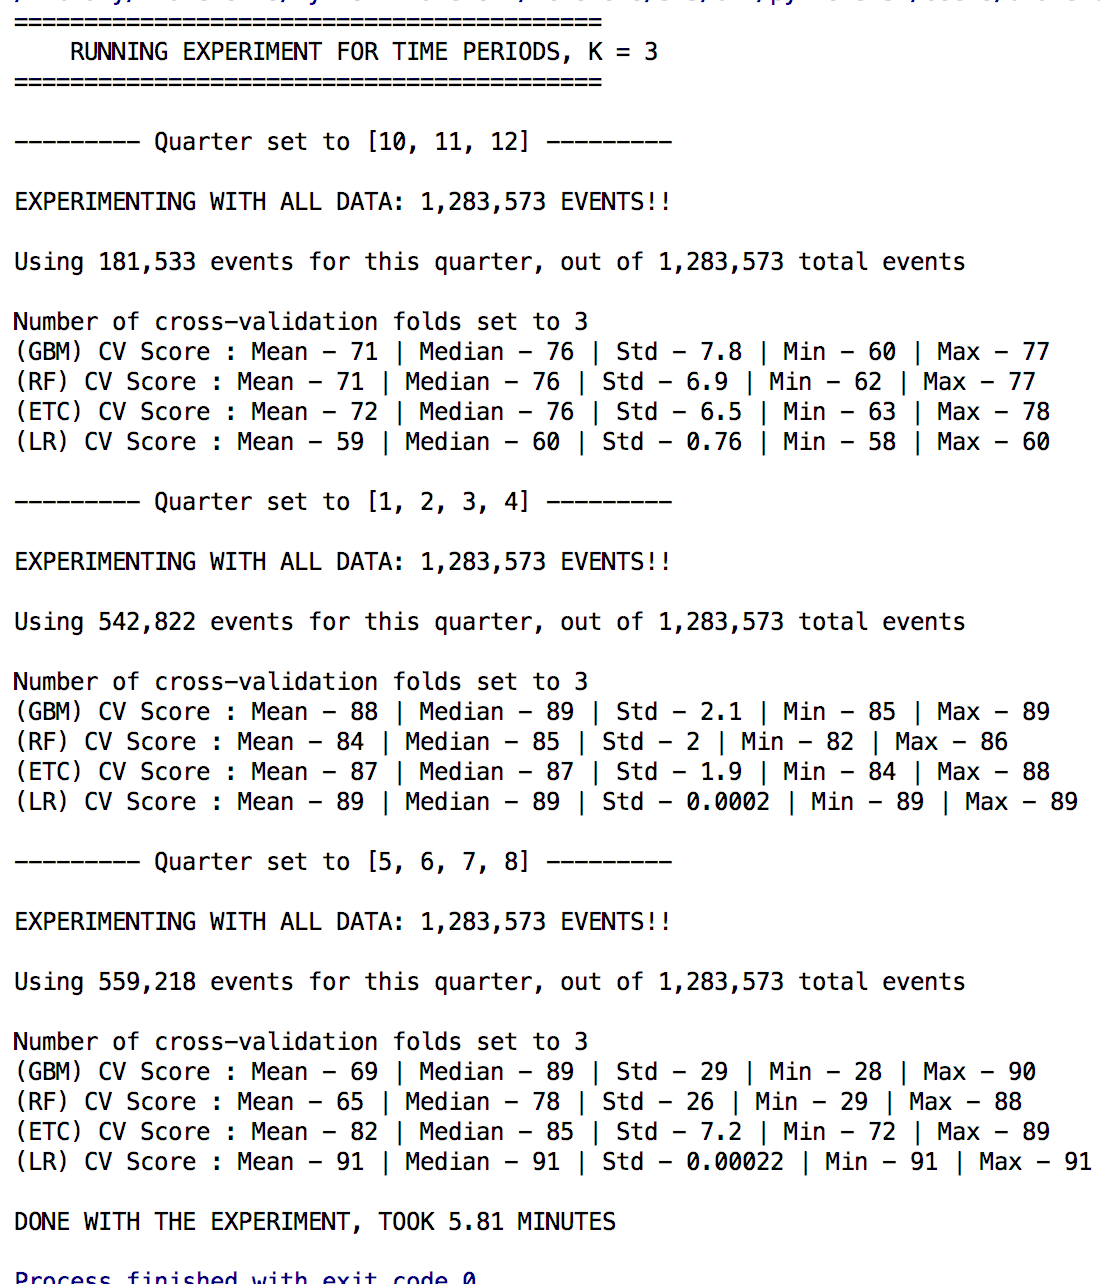

In [23]:
Image(filename='results_by_quarter_3_fold.png')

**Lets examine distribution of power outages by each quarter**
==============================================

In [44]:
all_months = [[10, 11, 12], [1, 2, 3, 4], [5, 6, 7, 8]]

print('=================================')
print('POWER OUTAGE DISTRIBUTION BY QUARTER')
print('=================================')
for q in all_months:
    print ('Quarter ==> {}'.format(q))
    sms2_q = sms2[sms2['month_sent'].isin(q)]
    sms2_q2 = sms2_q[sms2_q.power_state!=-1]
    display(sms2_q2.power_state.value_counts(normalize=True))
    

POWER OUTAGE DISTRIBUTION BY QUARTER
Quarter ==> [10, 11, 12]


1    0.536409
0    0.463591
Name: power_state, dtype: float64

Quarter ==> [1, 2, 3, 4]


1    0.892073
0    0.107927
Name: power_state, dtype: float64

Quarter ==> [5, 6, 7, 8]


1    0.906031
0    0.093969
Name: power_state, dtype: float64

In [47]:
sms1.power_state.value_counts(normalize=True)

1    0.664187
0    0.335813
Name: power_state, dtype: float64

In [48]:
sms2.power_state.value_counts(normalize=True)

 1    0.664053
-1    0.216783
 0    0.119164
Name: power_state, dtype: float64

** SEASONALITY-MODEL PERFOMANCE BY MONTH**
----------------------------------------
Note that for fast throughut, K is set to 3.
Data split into three quarters. Quick inspection shows that perfomance varies alot by quarter.

In [68]:
r = []
filename_root = 'results_cv10_all_events_'
months = [10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8]

for idx, f in enumerate(months):
    filename = './' + filename_root + '[' + str(f) + '].csv' 
    df = pd.read_csv(filename)
    df['month'] = f
    
    if idx == 0:
        res = df
    
    if idx > 0:
        res = res.append(df)

In [66]:
res.month.unique()

array([10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8])

In [94]:
fig, ax1 = plt.subplots()
fig.set_size_inches(13, 8.5)

# Draw a nested barplot to show survival for class and sex
g = sns.factorplot(x="month", y="median", hue="model", data=res,
                   size=6, kind="bar", palette="muted", ax=ax1)

g.despine(left=True)

fig.savefig('perfomance_by_month.png')

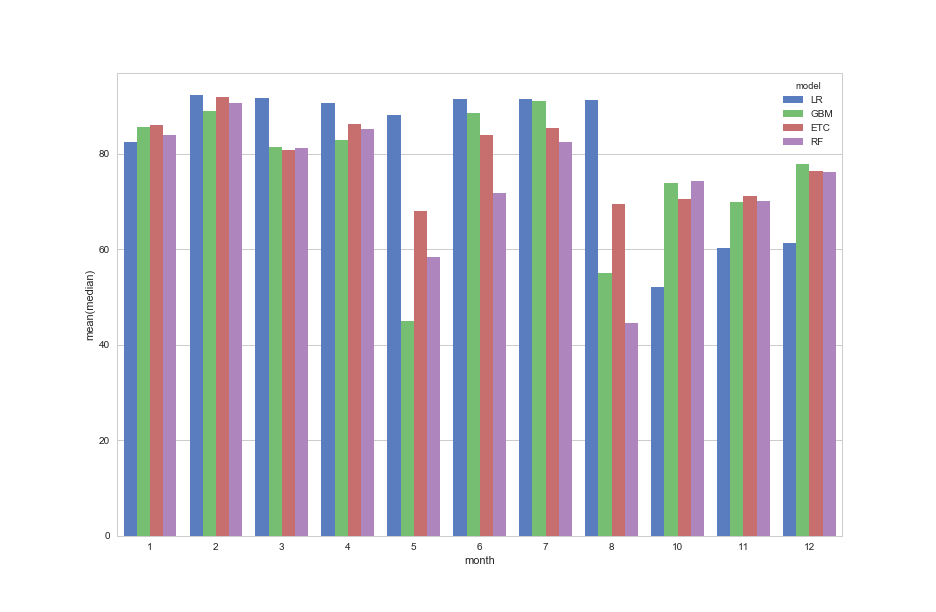

In [115]:
Image(filename='perfomance_by_month.png')